## Catboost Model

- Training data made with some overlap
- feature set 5; ie with all feature components

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from functools import reduce
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error
from IPython.display import display
import gen_features
from multiprocessing import Process, Value
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

fset = 5

#### 1) Extract dataset with features and target from csv files

In [2]:
%%time
# Read specified chunks of training data
if "feature_set{}.csv".format(fset) not in os.listdir("Features"):
    read_chunks = list(range(1,141))
    data_list = []
    folder = "temp"
    filename = 'text.txt'
    kwargs = {'gen_features' : gen_features.gen_features5,
              'overlap_ratio' : 0.25,
             }
    for k in tqdm_notebook(read_chunks):
        p = Process(target=gen_features.gen_dim_reduced_dataset,args=(k,),kwargs=kwargs)
        p.start()
        p.join()
        if k%20 == 0:
            with open(os.path.join(folder,filename),'r') as file:
                print(file.read())
    
    data_list = [pd.read_csv(os.path.join("temp","dim_reduced_train{}.csv".format(k))).iloc[:,1:] for k in read_chunks]
    data = pd.concat(data_list,axis=0,ignore_index=True)
    data.to_csv(os.path.join("Features","feature_set{}.csv".format(fset)))
else:
    print("Feature set {} already extracted.".format(fset))
    data = pd.read_csv(os.path.join("Features","feature_set{}.csv".format(fset))).iloc[:,1:]

Feature set 5 already extracted.
Wall time: 177 ms


In [3]:
x_df_raw = data.drop(['time_to_failure'],axis=1)
y_df = data['time_to_failure']

In [4]:
data.tail()

,mean,std,max,min,skew,kurtosis,r10_std,r100_std,r1000_std,1diff_mean,...,2diff_std,cumsum_max,num > q0.995,"fft_[10000,60000]Hz","fft_[60000,120000]Hz","fft_[120000,160000]Hz","fft_[160000,200000]Hz","fft_[200000,230000]Hz","fft_[230000,300000]Hz",time_to_failure
16709,4.489550,3.454761,64,-66,-0.108652,15.753992,1.575053,0.355076,0.213360,0.000047,...,4.821477,3866.306831,732,3499.865817,4737.961030,5722.738180,7724.769822,6426.278465,12569.033051,9.760800
16710,4.479615,3.448699,64,-66,-0.139434,17.734203,1.586974,0.356590,0.214267,-0.000017,...,4.813932,5418.292098,599,2929.155886,4203.377846,4882.782374,6053.966456,6169.025649,11202.868166,9.759796
16711,4.493480,3.670229,64,-66,-0.171886,19.836235,1.712873,0.359228,0.214935,0.000000,...,4.817990,4912.382225,379,2155.165677,3217.071359,4350.456984,5331.645518,5367.936766,9634.636614,9.759796
16712,4.565128,3.282740,46,-33,0.013554,6.720458,1.451719,0.354214,0.217487,0.000022,...,4.815550,2919.347230,223,1832.837599,2066.084532,2648.121990,3697.423229,3152.102198,5740.628906,9.759796
16713,4.648496,3.151858,26,-13,0.084372,1.003229,1.363908,0.311552,0.160577,-0.000627,...,4.784565,375.255639,39,531.531153,695.546392,1246.416692,990.924441,1080.122568,1645.085844,9.759796


#### 2) Normalize the data

In [5]:
scaler = StandardScaler()
x_df = scaler.fit_transform(x_df_raw.astype(np.float64))

#### 3) Explore the data (only basic comparisons, since this is only for the benchmark model)

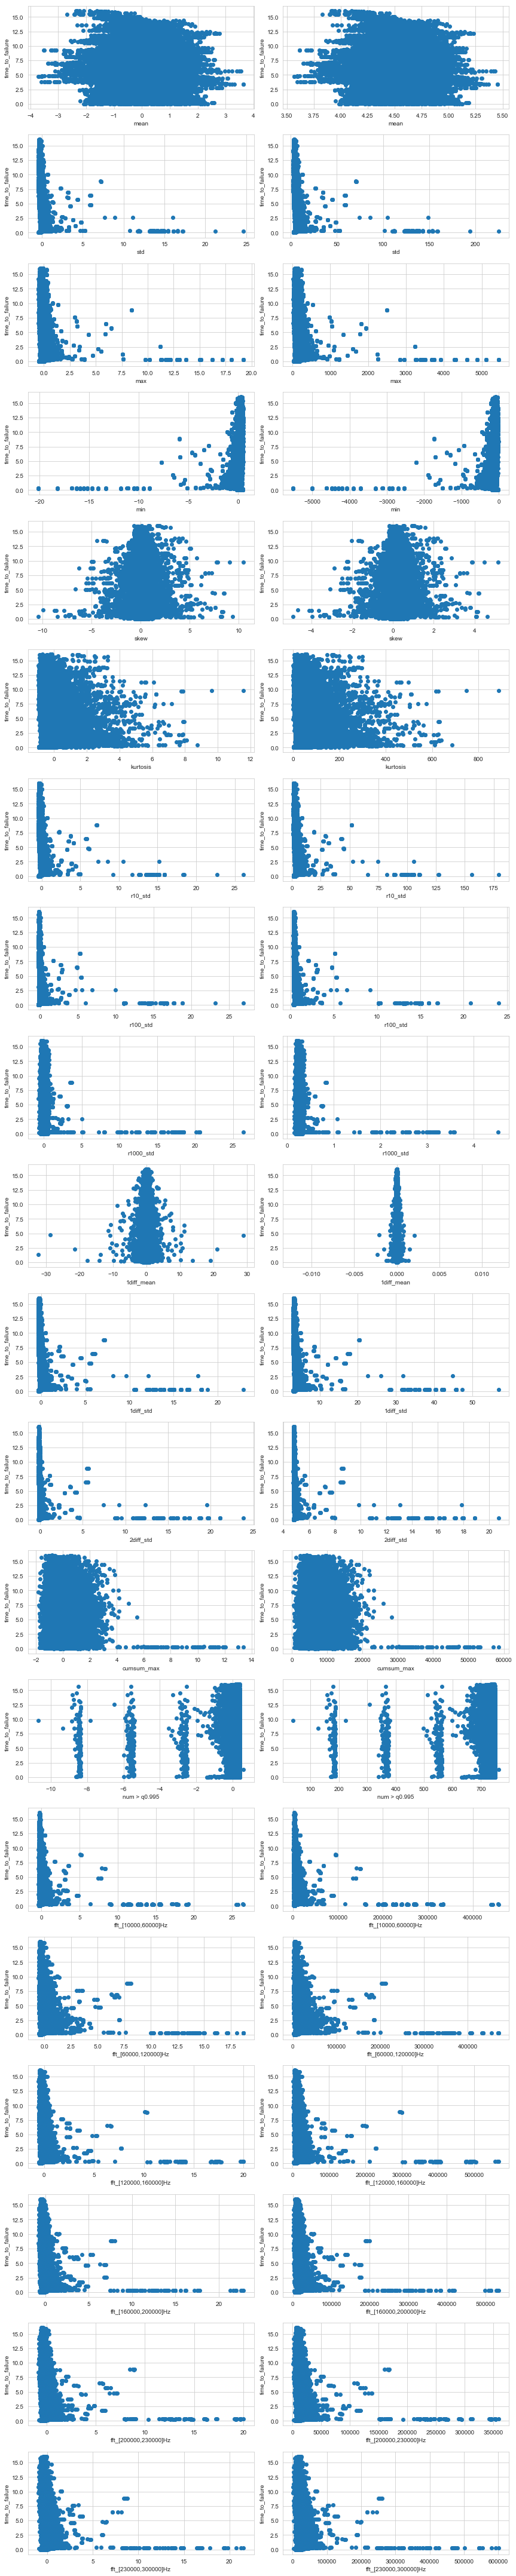

In [6]:
nrows = x_df.shape[1]
fig, axes = plt.subplots(nrows,2,figsize = (12,nrows*3))

for i,axis in enumerate(axes):
    axis[0].scatter(x_df[:,i],y_df)
    axis[0].set_xlabel(x_df_raw.columns[i])
    axis[0].set_ylabel('time_to_failure')
    
    axis[1].scatter(x_df_raw.iloc[:,i],y_df)
    axis[1].set_xlabel(x_df_raw.columns[i])
    axis[1].set_ylabel('time_to_failure')
    
plt.tight_layout()

#### 4) Split data into training and testing data

- Use 35% of data for testing

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df,y_df,test_size=0.35,random_state = 0)

#### 5) Set up a model with CatboostRegressor

In [8]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_absolute_error

In [9]:
regressor = CatBoostRegressor(loss_function='MAE',
                              random_seed=0,verbose=100)

init_res = cross_val_score(regressor,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=3, n_jobs=-1, verbose=5)

print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
    np.mean(init_res),np.std(init_res)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Mean CV score: -2.147, Std. Dev. of CV scores 0.027


In [140]:
regressor = CatBoostRegressor(iterations=15000,loss_function='MAE',
                              boosting_type='Ordered',random_seed=0,logging_level='Silent')
res = cross_val_score(regressor,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=5)

print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
    np.mean(res),np.std(res)))

Mean CV score: -2.040, Std. Dev. of CV scores 0.045


In [145]:
regressor_final = CatBoostRegressor(iterations=15000,loss_function='MAE',
                              boosting_type='Ordered', random_seed=0)
regressor_final.fit(X_train,y_train, use_best_model=True, eval_set=(X_test,y_test), verbose=500)
regressor.best_score_

0:	learn: 5.6170411	test: 5.7012636	best: 5.7012636 (0)	total: 51.4ms	remaining: 12m 50s
500:	learn: 2.4314501	test: 2.4462289	best: 2.4462289 (500)	total: 23s	remaining: 11m 5s
1000:	learn: 2.1060670	test: 2.1404476	best: 2.1404476 (1000)	total: 45.3s	remaining: 10m 33s
1500:	learn: 2.0627090	test: 2.1193636	best: 2.1193636 (1500)	total: 1m 7s	remaining: 10m 10s
2000:	learn: 2.0325941	test: 2.1076066	best: 2.1076066 (2000)	total: 1m 31s	remaining: 9m 52s
2500:	learn: 2.0074135	test: 2.0990716	best: 2.0990716 (2500)	total: 1m 54s	remaining: 9m 33s
3000:	learn: 1.9852751	test: 2.0920085	best: 2.0920085 (3000)	total: 2m 18s	remaining: 9m 14s
3500:	learn: 1.9657466	test: 2.0868266	best: 2.0868266 (3500)	total: 2m 42s	remaining: 8m 54s
4000:	learn: 1.9476293	test: 2.0830048	best: 2.0830048 (4000)	total: 3m 7s	remaining: 8m 34s
4500:	learn: 1.9299011	test: 2.0788051	best: 2.0788051 (4500)	total: 3m 31s	remaining: 8m 13s
5000:	learn: 1.9127462	test: 2.0749871	best: 2.0749871 (5000)	total: 3m

{'learn': {'MAE': 1.6772186756483662},
 'validation_0': {'MAE': 2.0289912262806626}}

In [186]:
for i,j in zip(x_df_raw.columns,regressor.feature_importances_):
    print("{} : {:.3f}".format(i,j))

mean : 10.080
std : 3.122
max : 4.770
min : 5.974
skew : 4.937
kurtosis : 13.557
r10_std : 2.534
r100_std : 3.424
r1000_std : 3.239
1diff_mean : 2.438
1diff_std : 10.084
2diff_std : 5.538
cumsum_max : 2.664
num > q0.995 : 2.567
fft_[10000,60000]Hz : 5.421
fft_[60000,120000]Hz : 3.964
fft_[120000,160000]Hz : 3.830
fft_[160000,200000]Hz : 3.267
fft_[200000,230000]Hz : 3.832
fft_[230000,300000]Hz : 4.759


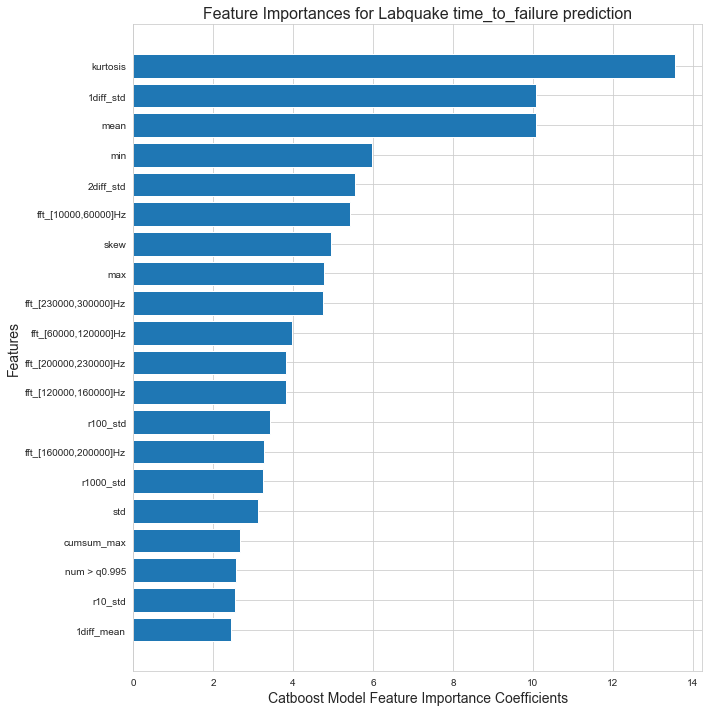

In [214]:
fig,axis = plt.subplots(figsize=(10,10))
axis.barh(x_df_raw.columns[np.argsort(regressor.feature_importances_)],
          np.sort(regressor.feature_importances_))
plt.ylabel('Features',fontsize=14)
plt.title(r'Feature Importances for Labquake time_to_failure prediction',fontsize=16)
plt.xlabel(r'Catboost Model Feature Importance Coefficients',fontsize=14)
plt.tight_layout()
plt.savefig("catboost_model_feature_importance")

In [185]:
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

train_score = mean_absolute_error(y_train,y_train_pred)
test_score = mean_absolute_error(y_test,y_test_pred)

print(train_score)
print(test_score)

1.6772437067300434
2.028991226146675


### Plot Model results

In [153]:
catboost_pred = pd.DataFrame(regressor.predict(scaler.transform(data.iloc[:,:-1])),
                        index=data.index,columns = ['Catboost_fset{} Prediction'.format(fset)])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [157]:
benchmark_pred = pd.read_csv(os.path.join("Data","train_predictions","benchmark_train_pred_fset1.csv"))

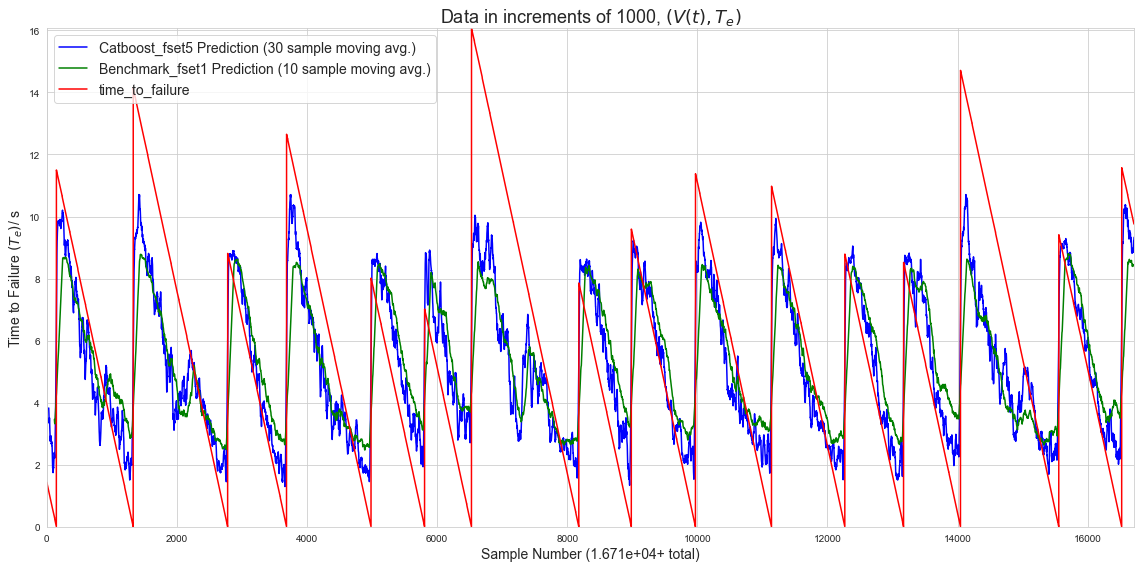

In [201]:
xdata = data.iloc[:,:-1]
fig,axis = plt.subplots(figsize=(16,8))
window = 30
axis.plot(catboost_pred.rolling(window).mean(),'b',
          label="Catboost_fset{} Prediction ({} sample moving avg.)".format(fset,window))
axis.plot(data.index[::4],benchmark_pred.rolling(window).mean(),'g',
          label="Benchmark_fset1 Prediction (10 sample moving avg.)".format(window))
axis.plot(data['time_to_failure'],'r')
plt.legend(fontsize=14)
plt.xlim((data.index[0],data.index[-1]))
plt.ylim((0,data['time_to_failure'].max()))
plt.ylabel(r'Time to Failure $(T_e)$/ s',fontsize=14)
plt.title(r'Data in increments of 1000, $(V(t), T_e)$',fontsize=18)
plt.xlabel(r'Sample Number ({:.3e}+ total)'.format(data.index[-1]),fontsize=14)
plt.tight_layout()
plt.savefig("catboost_model")

### Make Kaggle Competition Submission csv

In [183]:
if "submission_features{}.csv".format(fset) not in os.listdir("Features"):
    gen_features.gen_submission_features(gen_features=gen_features.gen_features5,fset=fset)

In [184]:
submission_raw = pd.read_csv(os.path.join("Features","submission_features5.csv")).iloc[:,1:]
submission = pd.concat([submission_raw['seg_id'],
                        pd.Series(regressor.predict(scaler.transform(submission_raw.iloc[:,1:].values)),name='time_to_failure')],
                      axis=1)
submission.to_csv(os.path.join("Submissions","Catboost_fset5.csv"),index=False)